<a href="https://colab.research.google.com/github/Mehdi007bond/Predictive_maintenance_Project/blob/main/Predictive_maintenance_Project_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# I started by generating the dataset so i can work


In [4]:
import pandas as pd
import numpy as np
import datetime

# --- 1. Configuration Générale ---
N_LINES = 4  # Nombre de lignes de production à simuler
DAYS_PER_MACHINE = 60
SAMPLES_PER_HOUR = 4
N_SAMPLES_PER_DAY = 24 * SAMPLES_PER_HOUR
TOTAL_SAMPLES_PER_MACHINE = DAYS_PER_MACHINE * N_SAMPLES_PER_DAY

# --- Paramètres de simulation (MIS À JOUR) ---
# Notre "état de panne" (cible=1) commence 58h avant la panne
# pour atteindre notre objectif de 4.02%
FAILURE_STATE_HOURS = 58
FAILURE_STATE_SAMPLES = FAILURE_STATE_HOURS * SAMPLES_PER_HOUR

# --- 2. Profils des Machines ---
def get_machine_parameters(machine_type):
    """Définit les profils de capteurs et de défaillance pour chaque type de machine."""

    if machine_type == 'Fraiseuse':
        return {
            'BASE_TEMP': 45.0, 'TEMP_NOISE': 2.0, 'TEMP_DEGRADE_RATE': 0.1,
            'BASE_VIB': 1.2, 'VIB_NOISE': 0.3, 'VIB_DEGRADE_RATE': 0.1,
            'BASE_CUR': 10.0, 'CUR_NOISE': 0.5, 'CUR_DEGRADE_RATE': 0.08,
            'BASE_TORQUE': 80.0, 'TORQUE_NOISE': 3.0, 'TORQUE_DEGRADE_RATE': 0.15
        }
    elif machine_type == 'Convoyeur':
        return {
            'BASE_TEMP': 30.0, 'TEMP_NOISE': 1.0, 'TEMP_DEGRADE_RATE': 0.05,
            'BASE_VIB': 0.4, 'VIB_NOISE': 0.1, 'VIB_DEGRADE_RATE': 0.03,
            'BASE_CUR': 3.0, 'CUR_NOISE': 0.1, 'CUR_DEGRADE_RATE': 0.15,
            'BASE_TORQUE': 20.0, 'TORQUE_NOISE': 1.0, 'TORQUE_DEGRADE_RATE': 0.05
        }
    elif machine_type == 'Machine_de_finition':
        return {
            'BASE_TEMP': 35.0, 'TEMP_NOISE': 0.5, 'TEMP_DEGRADE_RATE': 0.03,
            'BASE_VIB': 0.2, 'VIB_NOISE': 0.05, 'VIB_DEGRADE_RATE': 0.08,
            'BASE_CUR': 2.0, 'CUR_NOISE': 0.1, 'CUR_DEGRADE_RATE': -0.05,
            'BASE_TORQUE': 10.0, 'TORQUE_NOISE': 0.5, 'TORQUE_DEGRADE_RATE': -0.02
        }
    else:
        raise ValueError("Type de machine inconnu")

# --- 3. Fonction de Génération (Simplifiée) ---
def generate_machine_data(machine_id, machine_type, production_line, start_date):

    print(f"Génération des données pour Machine ID: {machine_id} (Type: {machine_type})...")

    params = get_machine_parameters(machine_type)
    total_samples = TOTAL_SAMPLES_PER_MACHINE

    time_offset_seconds = np.random.randint(0, 30)
    base_timestamps = [start_date + datetime.timedelta(hours=i/SAMPLES_PER_HOUR) for i in range(total_samples)]
    timestamps = [ts + datetime.timedelta(seconds=time_offset_seconds) for ts in base_timestamps]

    # Initialisation des capteurs
    temp = np.random.normal(loc=params['BASE_TEMP'], scale=params['TEMP_NOISE'], size=total_samples)
    vib = np.random.normal(loc=params['BASE_VIB'], scale=params['VIB_NOISE'], size=total_samples)
    curr = np.random.normal(loc=params['BASE_CUR'], scale=params['CUR_NOISE'], size=total_samples)
    torque = np.random.normal(loc=params['BASE_TORQUE'], scale=params['TORQUE_NOISE'], size=total_samples)

    # Feature "Odomètre": total_working_hours
    total_working_hours = (np.arange(total_samples) / SAMPLES_PER_HOUR).round(2)

    # --- CIBLE ML (Simplifiée) ---
    # 0 = 'Healthy', 1 = 'Failing'
    failure = np.zeros(total_samples, dtype=int)

    # Définir le point de panne exact
    failure_sample = total_samples - np.random.randint(N_SAMPLES_PER_DAY * 3, N_SAMPLES_PER_DAY * 15)

    # L'état de panne commence 58h avant
    failing_state_start_sample = failure_sample - FAILURE_STATE_SAMPLES

    # Mettre la cible à 1 pendant l'état de panne
    failure[failing_state_start_sample:failure_sample] = 1

    # Appliquer la dégradation des capteurs PENDANT l'état de panne
    for i in range(failing_state_start_sample, failure_sample):
        progress = (i - failing_state_start_sample) / (failure_sample - failing_state_start_sample)
        temp[i] += params['TEMP_DEGRADE_RATE'] * progress * 20
        vib[i] += params['VIB_DEGRADE_RATE'] * progress * 15
        curr[i] += params['CUR_DEGRADE_RATE'] * progress * 10
        torque[i] += params['TORQUE_DEGRADE_RATE'] * progress * 10

    # --- Assemblage du DataFrame (Simplifié) ---
    df = pd.DataFrame({
        'timestamp': timestamps,
        'production_line': production_line,
        'machine_id': machine_id,
        'machine_type': machine_type,
        'temperature': temp.round(2),
        'vibration': vib.round(4),
        'current': curr.round(3),
        'torque': torque.round(2),
        'total_working_hours': total_working_hours,
        'failure': failure                  # NOTRE CIBLE ML (0 ou 1)
    })

    return df

# --- 4. Boucle Principale de Génération ---
print("Démarrage de la génération du dataset (Cible = failure)...")
all_data_frames = []
start_date = datetime.datetime(2024, 1, 1)
machine_id_counter = 1
machine_types = ['Fraiseuse', 'Convoyeur', 'Machine_de_finition']

for i in range(N_LINES):
    line_name = f"Line_{i+1}"
    print(f"\n--- Génération des données pour {line_name} ---")
    for machine_type in machine_types:
        machine_df = generate_machine_data(
            machine_id=machine_id_counter,
            machine_type=machine_type,
            production_line=line_name,
            start_date=start_date
        )
        all_data_frames.append(machine_df)
        machine_id_counter += 1

# --- 5. Finalisation : Mélange et Sauvegarde ---
print("\nFinalisation du dataset...")
full_dataset = pd.concat(all_data_frames)

print("Tri du dataset par timestamp pour simuler la collecte 'temps réel'...")
full_dataset.sort_values(by='timestamp', inplace=True)
full_dataset.reset_index(drop=True, inplace=True)

print("\nDataset de CLASSIFICATION (4%) généré et mélangé !")
print(f"Nombre total d'échantillons: {len(full_dataset)}")

# Sauvegarde
output_filename = "production_line_STATE_BASED_4_PERCENT_data.csv"
full_dataset.to_csv(output_filename, index=False)
print(f"Dataset sauvegardé sous '{output_filename}'")

# Affichage d'un échantillon
print("\n--- Aperçu du Dataset ---")
print(full_dataset.head(10))

print("\n--- Distribution de la Cible (failure) ---")
print(full_dataset['failure'].value_counts())
target_rate = full_dataset['failure'].mean() * 100
print(f"Pourcentage de 'failure' (1): {target_rate:.2f}%")

Démarrage de la génération du dataset (Cible = failure)...

--- Génération des données pour Line_1 ---
Génération des données pour Machine ID: 1 (Type: Fraiseuse)...
Génération des données pour Machine ID: 2 (Type: Convoyeur)...
Génération des données pour Machine ID: 3 (Type: Machine_de_finition)...

--- Génération des données pour Line_2 ---
Génération des données pour Machine ID: 4 (Type: Fraiseuse)...
Génération des données pour Machine ID: 5 (Type: Convoyeur)...
Génération des données pour Machine ID: 6 (Type: Machine_de_finition)...

--- Génération des données pour Line_3 ---
Génération des données pour Machine ID: 7 (Type: Fraiseuse)...
Génération des données pour Machine ID: 8 (Type: Convoyeur)...
Génération des données pour Machine ID: 9 (Type: Machine_de_finition)...

--- Génération des données pour Line_4 ---
Génération des données pour Machine ID: 10 (Type: Fraiseuse)...
Génération des données pour Machine ID: 11 (Type: Convoyeur)...
Génération des données pour Machine ID: 

# Starting by exploratory data analysis

In [5]:
df = full_dataset
display(df.head(10))
display(df.shape)
df.isna().sum()
display(df.describe())
#


,timestamp,production_line,machine_id,machine_type,temperature,vibration,current,torque,total_working_hours,failure
0,2024-01-01 00:00:00,Line_2,4,Fraiseuse,45.30,0.8868,8.943,79.43,0.0,0
1,2024-01-01 00:00:07,Line_1,3,Machine_de_finition,34.55,0.2182,2.056,9.32,0.0,0
2,2024-01-01 00:00:09,Line_3,7,Fraiseuse,43.30,0.8155,9.439,74.05,0.0,0
3,2024-01-01 00:00:09,Line_4,12,Machine_de_finition,34.79,0.2235,1.911,9.72,0.0,0
4,2024-01-01 00:00:11,Line_2,5,Convoyeur,30.95,0.4217,2.976,19.44,0.0,0
5,2024-01-01 00:00:13,Line_2,6,Machine_de_finition,34.63,0.1757,1.926,9.39,0.0,0
6,2024-01-01 00:00:18,Line_3,8,Convoyeur,31.44,0.2785,3.196,20.82,0.0,0
7,2024-01-01 00:00:20,Line_3,9,Machine_de_finition,35.00,0.2545,1.814,10.18,0.0,0
8,2024-01-01 00:00:21,Line_4,11,Convoyeur,29.68,0.5199,3.214,19.65,0.0,0
9,2024-01-01 00:00:23,Line_1,2,Convoyeur,30.16,0.5339,2.798,19.96,0.0,0


(69120, 10)

,timestamp,machine_id,temperature,vibration,current,torque,total_working_hours,failure
count,69120,69120.000000,69120.000000,69120.000000,69120.000000,69120.000000,69120.000000,69120.000000
mean,2024-01-30 23:52:45.333333248,6.500000,36.688547,0.621673,5.014119,36.673976,719.875000,0.040278
min,2024-01-01 00:00:00,1.000000,26.050000,0.001200,1.293000,7.910000,0.000000,0.000000
25%,2024-01-15 23:56:21.750000128,3.750000,30.700000,0.230800,2.065000,10.330000,359.937500,0.000000
50%,2024-01-30 23:52:43.500000,6.500000,35.010000,0.413100,3.005000,20.010000,719.875000,0.000000
75%,2024-02-14 23:49:05.249999872,9.250000,43.670000,1.017300,9.681000,77.980000,1079.812500,0.000000
max,2024-02-29 23:45:27,12.000000,53.540000,3.373100,12.149000,92.950000,1439.750000,1.000000
std,NaN,3.452078,6.380094,0.493585,3.581602,30.979362,415.695195,0.196611


In [6]:
df.info()
df.columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69120 entries, 0 to 69119
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   timestamp            69120 non-null  datetime64[ns]
 1   production_line      69120 non-null  object        
 2   machine_id           69120 non-null  int64         
 3   machine_type         69120 non-null  object        
 4   temperature          69120 non-null  float64       
 5   vibration            69120 non-null  float64       
 6   current              69120 non-null  float64       
 7   torque               69120 non-null  float64       
 8   total_working_hours  69120 non-null  float64       
 9   failure              69120 non-null  int64         
dtypes: datetime64[ns](1), float64(5), int64(2), object(2)
memory usage: 5.3+ MB


Index(['timestamp', 'production_line', 'machine_id', 'machine_type',
       'temperature', 'vibration', 'current', 'torque', 'total_working_hours',
       'failure'],
      dtype='object')

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

for col in ['failure'] :
  col_counts = df[col].value_counts()
  print(col_counts)



failure
0    66336
1     2784
Name: count, dtype: int64


array([[<Axes: title={'center': 'timestamp'}>,
        <Axes: title={'center': 'machine_id'}>,
        <Axes: title={'center': 'temperature'}>],
       [<Axes: title={'center': 'vibration'}>,
        <Axes: title={'center': 'current'}>,
        <Axes: title={'center': 'torque'}>],
       [<Axes: title={'center': 'total_working_hours'}>,
        <Axes: title={'center': 'failure'}>, <Axes: >]], dtype=object)

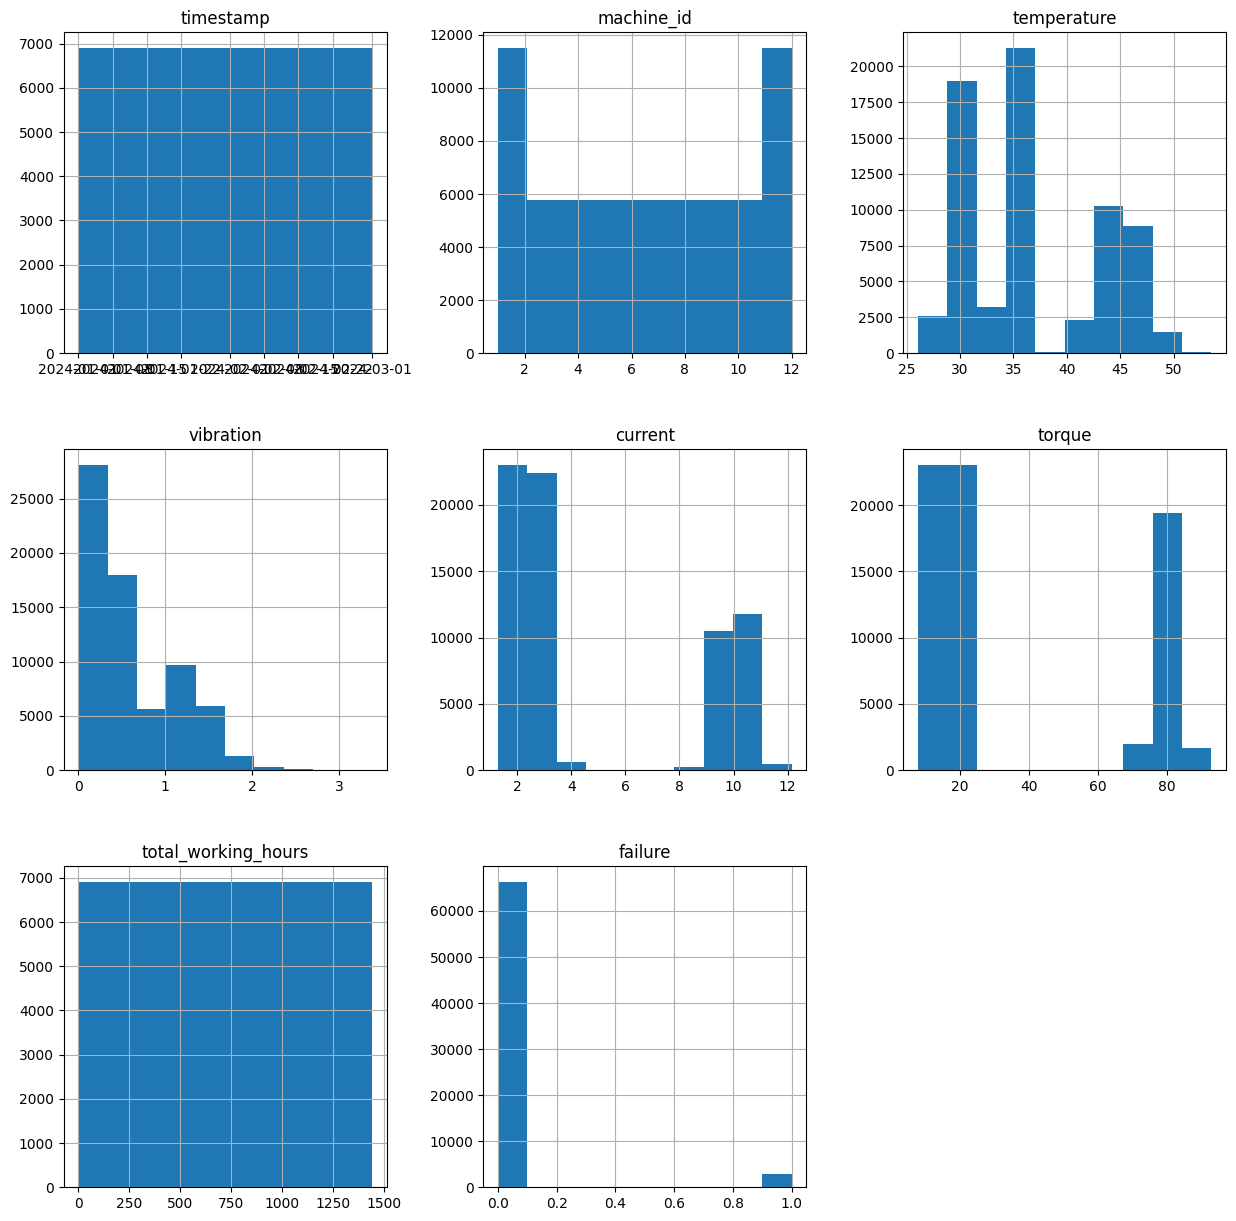

In [8]:
df.hist(figsize=(15,15))

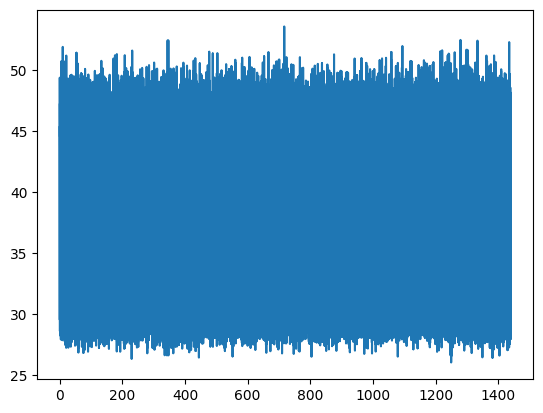

,timestamp,production_line,machine_id,machine_type,temperature,vibration,current,torque,total_working_hours,failure,Failure_Type
1,2024-01-01 00:00:07,Line_1,3,Machine_de_finition,34.55,0.2182,2.056,9.32,0.00,0,No failure
13,2024-01-01 00:15:07,Line_1,3,Machine_de_finition,34.14,0.1353,1.928,10.15,0.25,0,No failure
25,2024-01-01 00:30:07,Line_1,3,Machine_de_finition,35.64,0.2437,2.135,11.05,0.50,0,No failure
37,2024-01-01 00:45:07,Line_1,3,Machine_de_finition,34.26,0.1943,2.017,9.99,0.75,0,No failure
49,2024-01-01 01:00:07,Line_1,3,Machine_de_finition,34.35,0.1939,1.822,10.05,1.00,0,No failure
...,...,...,...,...,...,...,...,...,...,...,...
69061,2024-02-29 22:45:07,Line_1,3,Machine_de_finition,34.84,0.2307,2.160,9.76,1438.75,0,No failure
69073,2024-02-29 23:00:07,Line_1,3,Machine_de_finition,35.92,0.1906,1.888,9.88,1439.00,0,No failure
69085,2024-02-29 23:15:07,Line_1,3,Machine_de_finition,35.31,0.2498,2.009,9.98,1439.25,0,No failure
69097,2024-02-29 23:30:07,Line_1,3,Machine_de_finition,35.85,0.1674,2.060,10.22,1439.50,0,No failure


,timestamp,production_line,machine_id,machine_type,temperature,vibration,current,torque,total_working_hours,failure,Failure_Type
0,2024-01-01 00:00:00,Line_2,4,Fraiseuse,45.30,0.8868,8.943,79.43,0.00,0,No failure
4,2024-01-01 00:00:11,Line_2,5,Convoyeur,30.95,0.4217,2.976,19.44,0.00,0,No failure
5,2024-01-01 00:00:13,Line_2,6,Machine_de_finition,34.63,0.1757,1.926,9.39,0.00,0,No failure
12,2024-01-01 00:15:00,Line_2,4,Fraiseuse,40.63,1.0727,10.368,82.60,0.25,0,No failure
16,2024-01-01 00:15:11,Line_2,5,Convoyeur,29.54,0.3574,3.054,19.28,0.25,0,No failure
...,...,...,...,...,...,...,...,...,...,...,...
69100,2024-02-29 23:30:11,Line_2,5,Convoyeur,29.84,0.3710,2.902,21.51,1439.50,0,No failure
69101,2024-02-29 23:30:13,Line_2,6,Machine_de_finition,34.68,0.2227,2.041,9.75,1439.50,0,No failure
69108,2024-02-29 23:45:00,Line_2,4,Fraiseuse,44.84,1.4521,10.145,76.67,1439.75,0,No failure
69112,2024-02-29 23:45:11,Line_2,5,Convoyeur,30.54,0.3966,2.720,20.51,1439.75,0,No failure


,timestamp,production_line,machine_id,machine_type,temperature,vibration,current,torque,total_working_hours,failure,Failure_Type
2,2024-01-01 00:00:09,Line_3,7,Fraiseuse,43.30,0.8155,9.439,74.05,0.00,0,No failure
6,2024-01-01 00:00:18,Line_3,8,Convoyeur,31.44,0.2785,3.196,20.82,0.00,0,No failure
7,2024-01-01 00:00:20,Line_3,9,Machine_de_finition,35.00,0.2545,1.814,10.18,0.00,0,No failure
14,2024-01-01 00:15:09,Line_3,7,Fraiseuse,46.32,0.8780,9.920,79.08,0.25,0,No failure
18,2024-01-01 00:15:18,Line_3,8,Convoyeur,31.10,0.2153,3.032,20.20,0.25,0,No failure
...,...,...,...,...,...,...,...,...,...,...,...
69102,2024-02-29 23:30:18,Line_3,8,Convoyeur,30.45,0.3375,2.966,19.88,1439.50,0,No failure
69103,2024-02-29 23:30:20,Line_3,9,Machine_de_finition,34.93,0.1626,1.934,9.03,1439.50,0,No failure
69111,2024-02-29 23:45:09,Line_3,7,Fraiseuse,43.54,1.4497,10.344,81.64,1439.75,0,No failure
69114,2024-02-29 23:45:18,Line_3,8,Convoyeur,30.14,0.3142,3.083,18.51,1439.75,0,No failure


,timestamp,production_line,machine_id,machine_type,temperature,vibration,current,torque,total_working_hours,failure,Failure_Type
3,2024-01-01 00:00:09,Line_4,12,Machine_de_finition,34.79,0.2235,1.911,9.72,0.00,0,No failure
8,2024-01-01 00:00:21,Line_4,11,Convoyeur,29.68,0.5199,3.214,19.65,0.00,0,No failure
11,2024-01-01 00:00:27,Line_4,10,Fraiseuse,48.12,1.3403,9.992,81.64,0.00,0,No failure
15,2024-01-01 00:15:09,Line_4,12,Machine_de_finition,34.18,0.2608,2.076,10.43,0.25,0,No failure
20,2024-01-01 00:15:21,Line_4,11,Convoyeur,30.57,0.3709,2.808,20.53,0.25,0,No failure
...,...,...,...,...,...,...,...,...,...,...,...
69104,2024-02-29 23:30:21,Line_4,11,Convoyeur,29.87,0.4699,2.930,21.62,1439.50,0,No failure
69107,2024-02-29 23:30:27,Line_4,10,Fraiseuse,44.84,0.7640,9.881,82.26,1439.50,0,No failure
69110,2024-02-29 23:45:09,Line_4,12,Machine_de_finition,34.97,0.1561,1.978,9.06,1439.75,0,No failure
69116,2024-02-29 23:45:21,Line_4,11,Convoyeur,27.98,0.5057,3.042,19.02,1439.75,0,No failure


<Figure size 1500x1500 with 0 Axes>

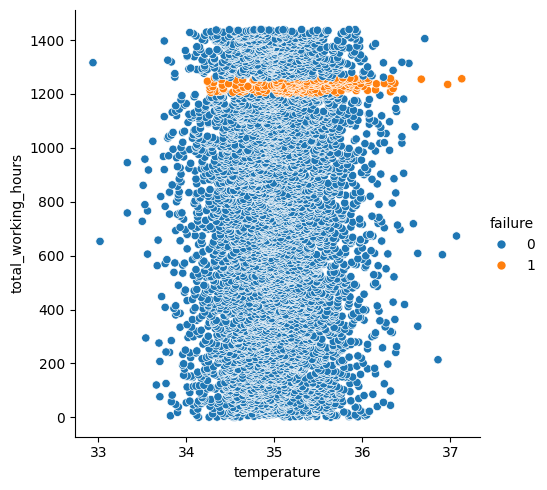

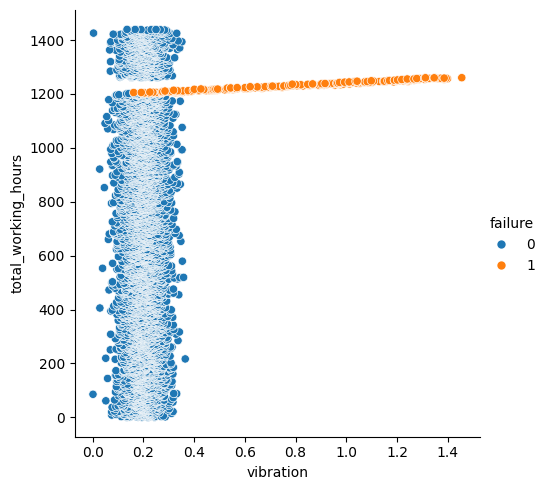

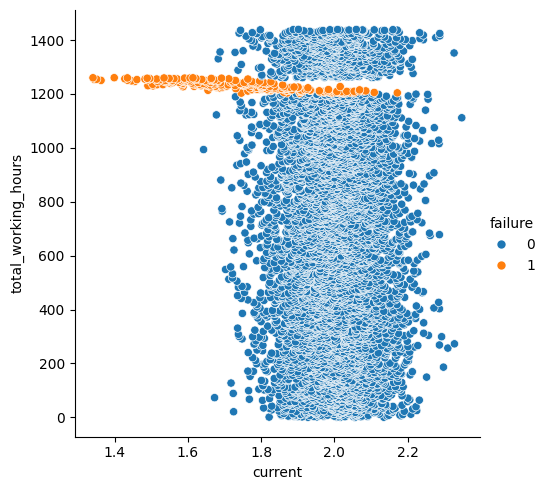

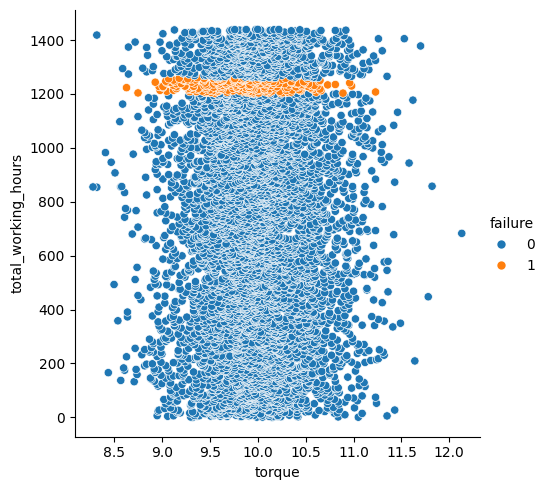

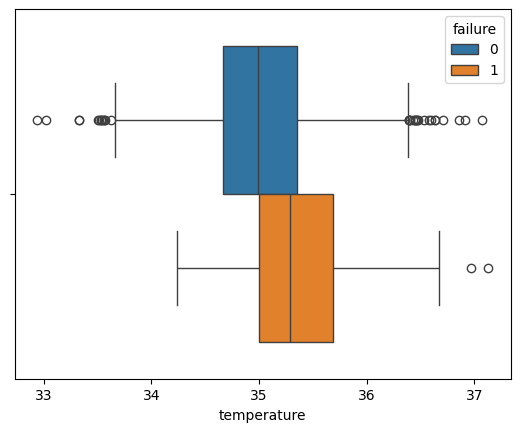

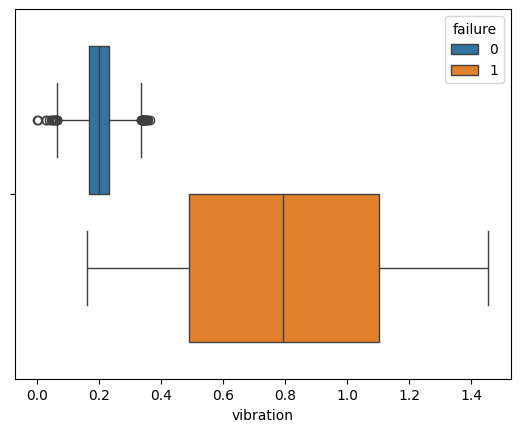

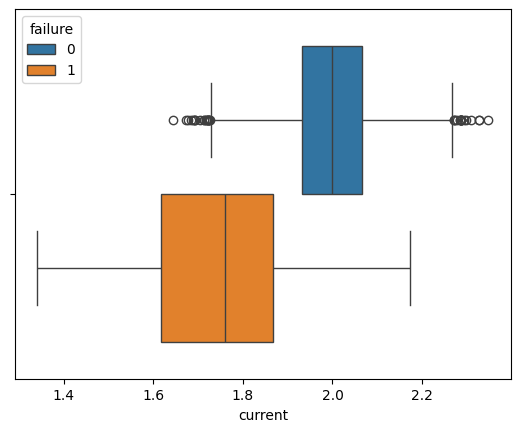

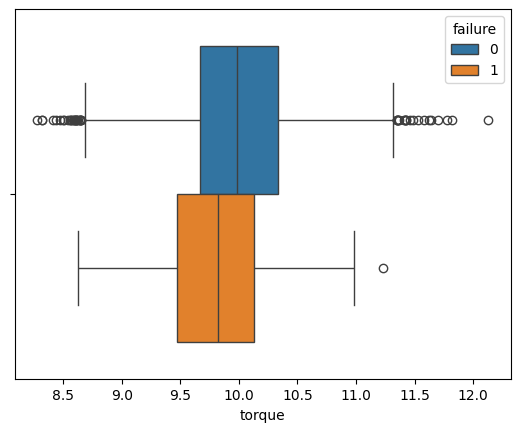

,timestamp,production_line,machine_id,machine_type,temperature,vibration,current,torque,total_working_hours,failure,Failure_Type
1,2024-01-01 00:00:07,Line_1,3,Machine_de_finition,34.55,0.2182,2.056,9.32,0.00,0,No failure
13,2024-01-01 00:15:07,Line_1,3,Machine_de_finition,34.14,0.1353,1.928,10.15,0.25,0,No failure
25,2024-01-01 00:30:07,Line_1,3,Machine_de_finition,35.64,0.2437,2.135,11.05,0.50,0,No failure
37,2024-01-01 00:45:07,Line_1,3,Machine_de_finition,34.26,0.1943,2.017,9.99,0.75,0,No failure
49,2024-01-01 01:00:07,Line_1,3,Machine_de_finition,34.35,0.1939,1.822,10.05,1.00,0,No failure
...,...,...,...,...,...,...,...,...,...,...,...
69061,2024-02-29 22:45:07,Line_1,3,Machine_de_finition,34.84,0.2307,2.160,9.76,1438.75,0,No failure
69073,2024-02-29 23:00:07,Line_1,3,Machine_de_finition,35.92,0.1906,1.888,9.88,1439.00,0,No failure
69085,2024-02-29 23:15:07,Line_1,3,Machine_de_finition,35.31,0.2498,2.009,9.98,1439.25,0,No failure
69097,2024-02-29 23:30:07,Line_1,3,Machine_de_finition,35.85,0.1674,2.060,10.22,1439.50,0,No failure


In [9]:
df.columns
failure_cols = ['temperature', 'vibration', 'current', 'torque']
def classify_failure_type(row):
  for col in failure_cols :
    if row[col] == 1 :
      return col
  return "No failure"

df["Failure_Type"] = df.apply(classify_failure_type, axis=1)


# The following line caused the ValueError and is removed:


plt.plot(df["total_working_hours"], df["temperature"], label="Temperature")
plt.show()

df.tail(100)
df_line2= df[(df['production_line'] == 'Line_2')]
df_line2
df_line1= df[(df['production_line'] == 'Line_1')]
df_line1
df_line3= df[(df['production_line'] == 'Line_3')]
df_line3
df_line4= df[(df['production_line'] == 'Line_4')]
# building a plot where we can see a evolution of each line (1 2 3)
#making a classification of each variable so we ca ddisplay it
df_line1 = df[(df['production_line'] == 'Line_1') & (df['machine_type'] == 'Machine_de_finition')]
criteria=['temperature', 'vibration', 'current', 'torque']


df.head()
display(df_line1 , df_line2 ,df_line3 ,df_line4)
plt.figure(figsize=(15,15))
for i in criteria:
  sns.relplot(x=i ,y='total_working_hours', hue='failure' , data=df_line1)
  plt.show()
for b in criteria:
  sns.boxplot(x=b , hue='failure' , data=df_line1)
  plt.show()
display(df_line1)

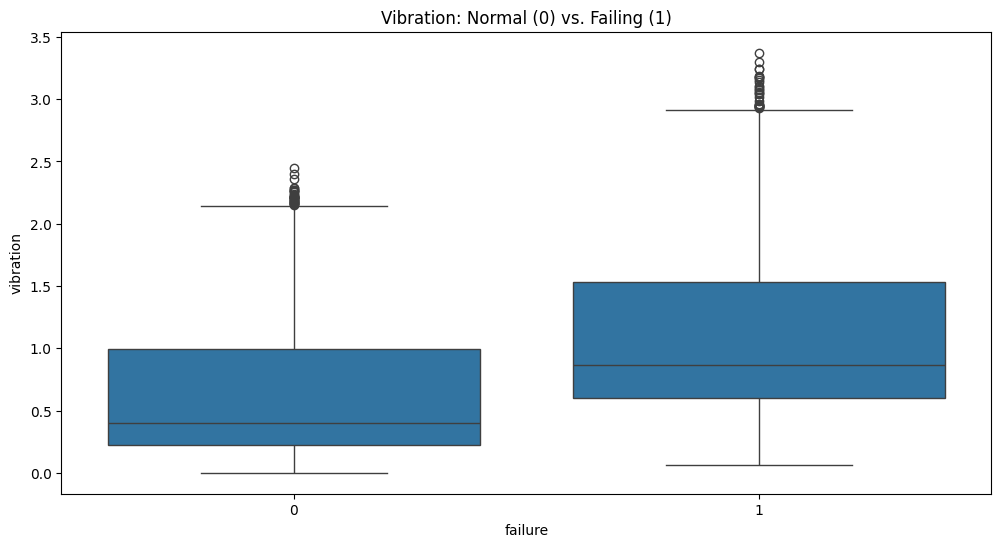

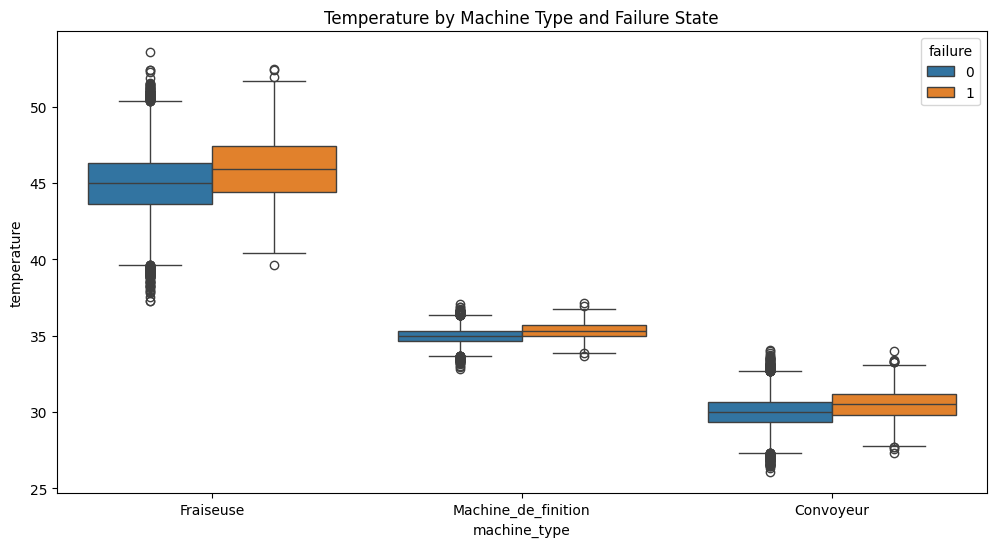

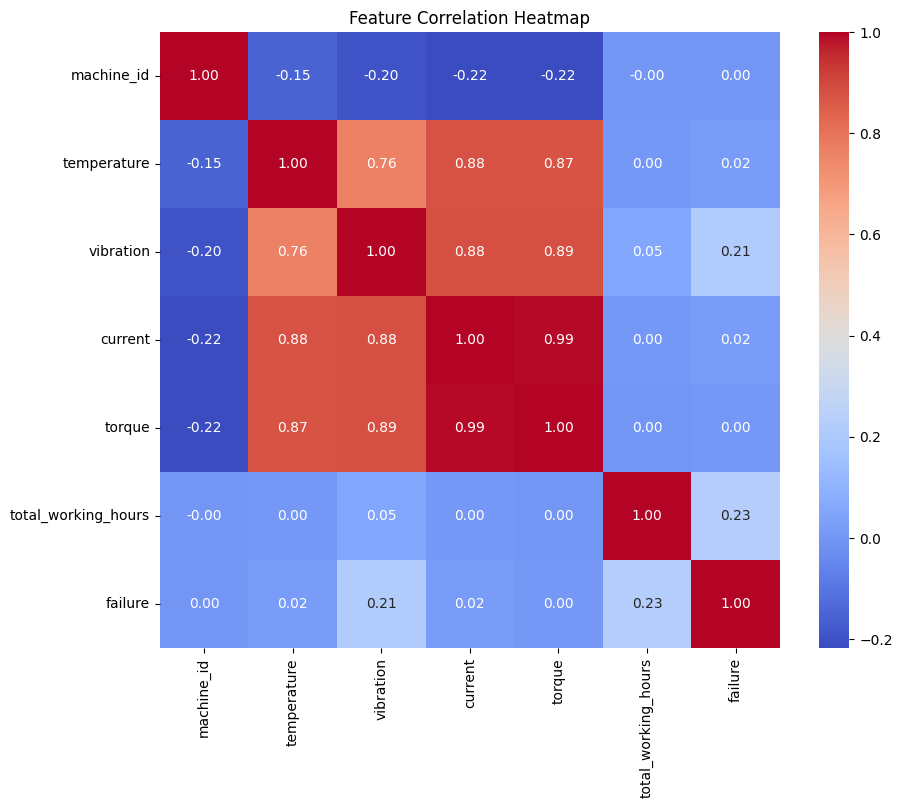

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

# 1. See the difference between Normal (0) and Failing (1) states

plt.figure(figsize=(12, 6))
sns.boxplot(x='failure', y='vibration', data=df)
plt.title('Vibration: Normal (0) vs. Failing (1)')
plt.show()

# 2. Compare machine types

plt.figure(figsize=(12, 6))
sns.boxplot(x='machine_type', y='temperature', hue='failure', data=df)
plt.title('Temperature by Machine Type and Failure State')
plt.show()

# 3. Check correlations

numeric_cols = df.select_dtypes(include=np.number)
plt.figure(figsize=(10, 8))
sns.heatmap(numeric_cols.corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Feature Correlation Heatmap')
plt.show()

In [11]:
# Display the correlation between 'current' and 'torque'
print("Correlation between Current and Torque:")
print(numeric_cols.corr().loc['current', 'torque'])

Correlation between Current and Torque:
0.9941540099417338


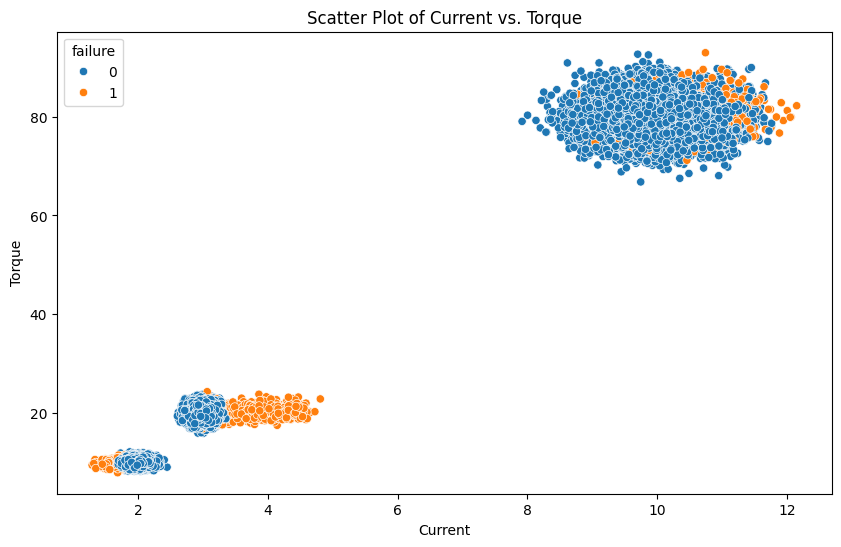

In [12]:

plt.figure(figsize=(10, 6))
sns.scatterplot(x='current', y='torque', hue='failure', data=df)
plt.title('Scatter Plot of Current vs. Torque')
plt.xlabel('Current')
plt.ylabel('Torque')
plt.show()

## After exploring the data and knowing the ones that have the most impact by weight

In [13]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# starting building our model

In [15]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
# 1. Prepare your data for LSTM
# Select relevant features for the model
features = ['temperature', 'vibration', 'current', 'torque', 'total_working_hours']
data = df[features].values
target = df['failure'].values

# Scale the features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Create sequences for training
sequence_length = 60 # You can adjust this based on how many past samples you want to use to predict failure
X, y = [], []
for i in range(len(scaled_data) - sequence_length):
    X.append(scaled_data[i:i+sequence_length])
    y.append(target[i+sequence_length]) # Predict the failure state at the end of the sequence

X = np.array(X)
y = np.array(y)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False) # shuffle=False for time series data

# Reshape X for LSTM input: (samples, timesteps, features)
# The shape is already correct from the sequence creation, but explicitly check
print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of X_test: {X_test.shape}")

# 2. Build the LSTM model
model = Sequential()
model.add(LSTM(units=50, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2)) # Optional: for regularization
model.add(Dense(units=1, activation='sigmoid')) # Output layer for binary classification (failure or not failure)

# 3. Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy']) # Use binary_crossentropy and accuracy for classification

# 4. Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test)) # Reduced epochs for quicker run

# 5. Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

# 6. Make predictions (example)
# Predict failure for the last sequence in the test set
last_sequence_test = X_test[-1].reshape(1, X_test.shape[1], X_test.shape[2])
predicted_failure_prob = model.predict(last_sequence_test)
predicted_failure = (predicted_failure_prob > 0.5).astype(int)
print(f"Predicted failure probability for the last test sequence: {predicted_failure_prob[0][0]:.4f}")
print(f"Predicted failure state for the last test sequence: {predicted_failure[0][0]}")

Shape of X_train: (55248, 60, 5)
Shape of X_test: (13812, 60, 5)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
1727/1727 ━━━━━━━━━━━━━━━━━━━━ 46s 25ms/step - accuracy: 0.9766 - loss: 1.2750 - val_accuracy: 0.8915 - val_loss: 0.3465
Epoch 2/10
1727/1727 ━━━━━━━━━━━━━━━━━━━━ 43s 25ms/step - accuracy: 0.9770 - loss: 0.0677 - val_accuracy: 0.8915 - val_loss: 0.3550
Epoch 3/10
1727/1727 ━━━━━━━━━━━━━━━━━━━━ 44s 25ms/step - accuracy: 0.9773 - loss: 0.0637 - val_accuracy: 0.8915 - val_loss: 0.3702
Epoch 4/10
1727/1727 ━━━━━━━━━━━━━━━━━━━━ 41s 24ms/step - accuracy: 0.9763 - loss: 0.0825 - val_accuracy: 0.8915 - val_loss: 0.3931
Epoch 5/10
1727/1727 ━━━━━━━━━━━━━━━━━━━━ 44s 25ms/step - accuracy: 0.9770 - loss: 1426.5629 - val_accuracy: 0.8915 - val_loss: 0.4380
Epoch 6/10
1727/1727 ━━━━━━━━━━━━━━━━━━━━ 43s 25ms/step - accuracy: 0.9764 - loss: 16038615.0000 - val_accuracy: 0.8915 - val_loss: 0.3531
Epoch 7/10
1727/1727 ━━━━━━━━━━━━━━━━━━━━ 42s 24ms/step - accuracy: 0.9768 - loss: 0.0710 - val_accuracy: 0.8915 - val_loss: 0.3389
Epoch 8/10
1727/1727 ━━━━━━━━━━━━━━━━━━━━ 42s 24ms/step - accuracy